In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from astropy.table import Table
import time
from pandas import DataFrame, read_csv
import pandas as pd 
from mpl_toolkits.mplot3d import Axes3D
import copy
import pickle
import math
from scipy.spatial import KDTree
import time
import matplotlib.path as mpltPath
#from matplotlib.patches import Circle, Wedge, Polygon
import numpy.polynomial.polynomial as poly
import random
import seaborn

In [3]:
## I am using Ophiucus in this example
file = r'Ophiucius_DR2_2MASS_SDSS.csv'
df_cloud = pd.read_csv(file)


C:\Users\Kevin.Hall\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (96) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
Gmag = df_cloud["phot_g_mean_mag"].values
GBmag = df_cloud["phot_bp_mean_mag"].values
GRmag = df_cloud["phot_rp_mean_mag"].values
# 2MASS bands
Jmag = df_cloud["j_m"].values
Hmag = df_cloud["h_m"].values
Kmag = df_cloud["ks_m"].values
GK = Gmag - Kmag
# Other Important Data
plx = df_cloud["parallax"].values
Dist = 1000./plx
K_unc = df_cloud["ks_msigcom"].values
J_unc = df_cloud['j_msigcom'].values
H_unc = df_cloud['h_msigcom'].values
G_flux = df_cloud["phot_g_mean_flux"].values
G_flux_er = df_cloud["phot_g_mean_flux_error"].values
GB_flux = df_cloud['phot_bp_mean_flux'].values
GB_flux_er = df_cloud['phot_bp_mean_flux_error'].values
GR_flux = df_cloud['phot_rp_mean_flux'].values
GR_flux_er = df_cloud['phot_rp_mean_flux_error'].values
SNR = df_cloud['parallax_over_error']
SNR_flux = G_flux/G_flux_er
RA = df_cloud["ra"].values
DEC = df_cloud["dec"].values
AG = df_cloud['a_g_val']
starID = df_cloud['designation']
epoch = df_cloud['ref_epoch']

In [17]:
# FIT FUNCTION USING BOTH STAR MAG UNCERTAINTY AND STANDARD ERROR IN TEMPLATE
def StarFit(starBands,color_mags,starError,color_std_err,idval):
    
    
    if(len(starBands) == 6.0):
        new_starBands = []
        for i in range(len(starBands)):
            if(i == 0):
                G = starBands[i]
            else:
                G_X = G - starBands[i]
                new_starBands.append(G_X)
        new_starBands = np.array(new_starBands)
    else:
        new_starBands = np.array(starBands)

    template_bands = []
    template_err = []
    std_err = []
    for i in range(len(color_mags)):
        cm = color_mags[i,:]
        cm = cm[~np.isnan(cm)]
        cs = color_std_err[i,:]
        cs = cs[~np.isnan(cs)]
        template_bands.append(cm)
        template_err.append(cs)
    template_bands = np.array(template_bands)
    template_err = np.array(template_err)
    
    newStarError = []
    for i in range(len(starError)):
        if(i == 0):
            sigmaG = starError[i]
        else:
            sigma = starError[i]
            newStarError.append(np.sqrt(sigmaG**2+sigma**2))
    newStarError = np.array(newStarError)
    Chi2_vals = []
    
    QuadError = []
    for i in range(len(template_err)):
        QuadError.append(np.sqrt(newStarError**2 + template_err[i]**2))
    QuadError = np.array(QuadError)

    Chi = []
    for i in range(len(template_bands)):
        #print((template_bands[i]),len(new_starBands),len(QuadError[i]))
        Chi2 = ((template_bands[i] - new_starBands)**2/(QuadError[i])**2)
        Chi2 = np.sum(Chi2)
        
#         for j in range(len(new_starBands)):
#             Chi2 = Chi2 + ((template_bands[i,j] - new_starBands[j])**2/(QuadError[i,j])**2)
        Chi2 = Chi2/(len(new_starBands)-3)  # EDITED THIS LINE JUNE 7TH. GOT RID OF THE -1
        Chi2_vals.append(Chi2)
    
    Chi2_vals = np.array(Chi2_vals)
   
    red_Chi2 = []
    for i in range(len(Chi2_vals)):
        if(Chi2_vals[i] == np.min(Chi2_vals)):
            chi = Chi2_vals[i]
            
            best_fit = i
            #GK_val = spec
            val = idval[best_fit]
            #GK_val = val #G_K_int[index]
            quad = QuadError[i]
    return best_fit, chi, val, Chi2_vals, quad

In [18]:
def MagError(flux2,flux2_er,min_val):
    
    #Mag = 2.5*np.log10(flux1/flux2) + KnownMag
    Mag_er = np.sqrt((2.5/np.log(10)**2)*(flux2_er/flux2)**2)
    #Mag_er = np.sqrt(((2.5/(np.log(10)*flux1))*flux1_er)**2 + ((-2.5/(np.log(10)*flux2))*flux2_er)**2)
    if(Mag_er < min_val):
        Mag_er = min_val
    return Mag_er

In [19]:

# with open('AF_4.1_table.pickle', 'wb') as handle:
#     pickle.dump(new_dic_AF, handle, protocol=pickle.HIGHEST_PROTOCOL)

dic_AF = pickle.load( open( "Extinction_FiltersAll_G2_dr2_CCM_Rv_4.1.txt", "rb" ) )     



ind_G = 0
ind_Gb = 1
ind_Gr = 2
ind_H = 3
ind_J = 4
ind_K = 5


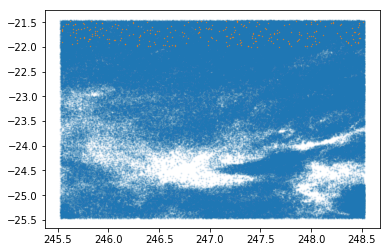

272
272
336739


In [6]:
## My method to select a certain region of stars from Ophiucus. You don't have to use this specific script to select the stars

import random
cornerRA = []
cornerDEC = []
G = []
GB = []
GR = []
Gflux = []
GBflux = []
GRflux = []
Gflux_err = []
GBflux_err = []
GRflux_err = []
cornerDist = []
cornerSNR = []
cornerFluxSNR = []
cornerID = []
#RA[i] >= 248.4 and DEC[i] <= -25.0

J = []
H = []
K = []
Jerr = []
Herr = []
Kerr = []
ag = []
for i in range(len(RA)):
    if(DEC[i] >= -22 and str(Gmag[i]) != 'nan' and str(GBmag[i]) != 'nan' and \
       str(GRmag[i]) != 'nan' and SNR[i] >50\
       and str(Jmag[i]) != 'nan' and str(Hmag[i]) != 'nan' and str(Kmag[i]) != 'nan' and str(G_flux[i]) != 'nan'\
       and str(GB_flux[i]) != 'nan' and str(GR_flux[i]) != 'nan' and str(G_flux_er[i]) != 'nan' and str(GB_flux_er[i]) != 'nan'\
       and str(GR_flux_er[i]) != 'nan' and str(J_unc[i]) != 'nan' and str(H_unc[i]) != 'nan' and str(K_unc[i]) != 'nan'\
      and str(Dist[i]) != 'nan' and (Dist[i]) <= 6000 and Dist[i] >= 0):
        G.append(Gmag[i])
        GB.append(GBmag[i])
        GR.append(GRmag[i])
        Gflux.append(G_flux[i])
        Gflux_err.append(G_flux_er[i])
        GBflux.append(GB_flux[i])
        GBflux_err.append(GB_flux_er[i])
        GRflux.append(GR_flux[i])
        GRflux_err.append(GR_flux_er[i])
        J.append(Jmag[i])
        H.append(Hmag[i])
        K.append(Kmag[i])
        Jerr.append(J_unc[i])
        Herr.append(H_unc[i])
        Kerr.append(K_unc[i])
        ag.append(AG[i])
        cornerRA.append(RA[i])
        cornerDEC.append(DEC[i])
        cornerDist.append(Dist[i])
        cornerSNR.append(SNR[i])
        cornerFluxSNR.append(SNR_flux[i])
        cornerID.append(starID[i])
G = np.array(G)
GB = np.array(GB)
GR = np.array(GR)
Gflux = np.array(Gflux)
GBflux = np.array(GBflux)
GRflux = np.array(GRflux)
Gflux_err = np.array(Gflux_err)
GBflux_err = np.array(GBflux_err)
GRflux_err = np.array(GRflux_err)
cornerRA = np.array(cornerRA)
cornerDEC = np.array(cornerDEC)
J = np.array(J)
H = np.array(H)
K = np.array(K)
Jerr = np.array(Jerr)
Herr = np.array(Herr)
Kerr = np.array(Kerr)
ag = np.array(ag)

GGB = G - GB
GGR = G - GR
GJ = G - J
GH = G - H
GK = G - K

cornerGaiaFluxs = np.array([Gflux[0],GBflux[0],GRflux[0]])
cornerGaiaFlux_ers = np.array([Gflux_err[0],GBflux_err[0],GRflux_err[0]])
cornerTmassErrors = np.array([Jerr[0],Herr[0],Kerr[0]])
cornerBands = np.array([GGB[0],GGR[0],GJ[0],GH[0],GK[0]])
#cornerBands = np.array([GGR[0],GJ[0],GH[0],GK[0]])


for i in range(1,len(G)):
    cornerGaiaFluxs = np.vstack((cornerGaiaFluxs,[Gflux[i],GBflux[i],GRflux[i]]))
    cornerGaiaFlux_ers = np.vstack((cornerGaiaFlux_ers,[Gflux_err[i],GBflux_err[i],GRflux_err[i]]))
    cornerTmassErrors = np.vstack((cornerTmassErrors,[Jerr[i],Herr[i],Kerr[i]]))
    cornerBands = np.vstack((cornerBands, [GGB[i],GGR[i],GJ[i],GH[i],GK[i]]))
    #cornerBands = np.vstack((cornerBands, [GGR[i],GJ[i],GH[i],GK[i]]))
    
    
plt.scatter(RA,DEC,s=1.0,alpha=0.1)
plt.scatter(cornerRA,cornerDEC,s=0.1,alpha=1.0)
#plt.scatter(cornerRA[n],cornerDEC[n],c='r')
plt.show()
print(len(G))

Distances = []
count = 0
for i in range(len(cornerDist)):
    if(str(cornerDist[i]) != 'nan' and (cornerDist[i]) <= 10000 and cornerDist[i] >= 0):
        count= count + 1
        Distances.append(cornerDist[i])
print(count)
print(len(Gmag))
ID = random.sample(range(0, len(cornerBands)), 40)

In [29]:
def KNN_Fit(Bands,n,bigArray,file,Nvalue,BestVals,printInfo=False):
    
#     Bands: This variable collects all of the colors for all stars in a given region of the sky
    
#     n: this is a parameter that randomly selects one of the stars in the region. I have a cell below that randomly defines n

#     bigArray: This is the array that stores all possible fudge factors. I have a cell below that has the script to do this

#     file: String that is the name of the file containing all Av Templates using CCM Rv. 4.0

#     Nvalue: This is an intger that defines the amount of nearest neighbors it will calculate in the KDTree

#     BestVals: This is an integer that defines the amount of all nearest neighbors to find after all KDtrees have run

#     printInfo: This will print out the star intrinsic G-K, Av, Fudge Factors, and index. This is False by default.


    factorArray = []
    extBands = np.array([Bands[n]])
    allDistVals = np.array([])
    indices = np.array([])
    loopStep = np.array([])
    start = time.time()
    minNeighbor = []

    AV_list = np.array(file['Av']) # define the possible Av values 0 - 21
    Temps = file['Temps'] # Grab the Templates

    for i in range(len(AV_list)): # Iterate through each AV value
        color_wFact = [] # Array that will store colors with the fudge factors applied
        curAv = Temps[AV_list[i]]
        colors = np.array(curAv['Colors'])
        colors_copy = np.array(copy.copy(colors)) # I like to copy this to avoid any possible change to original file
        factorArray = []
        for factor in range(len(bigArray)): # Iterate through all possible fudge factors and apply them to templates
            factorArray = np.array(bigArray[factor]) 
            factorArray = np.append(factorArray,[bigArray[factor,2],bigArray[factor,2]]) # 2MASS Bands share same factor
            color_wFact.append(np.multiply(colors_copy,factorArray)) # Multiplies colors by Fudge Factors

        size = int(np.size(color_wFact)/5)
        al = (copy.copy(color_wFact))
        al = np.reshape(al,(size,5)) # Method to organize array properly
        tree = cKDTree(al,1e13,balanced_tree=False)
        dist, ind = tree.query(extBands,k=Nvalue) # Kdtree step, the 1e13 is something I found that increases speed. I have found 
        indices = np.append(indices, ind) #                    no indications that it causes the script to run erroneously
        loopStep = np.append(loopStep, np.full((1,20), i)) # Appends the same index value since it iterates by Av value
        allDistVals = np.append(allDistVals, dist)



    count = 0
    listOfIndices = []
    copy_minArray = np.array(copy.copy(allDistVals))
    copy_index = np.array(copy.copy(indices))
    listOfLoops = []
    listOfDist = []
    while(count <= BestVals):  # BestVals is the number of best overall nearest neighbor values from the array created above.

        for i in range(len(copy_minArray)):
            if(copy_minArray[i] == np.nanmin(copy_minArray)):
                listOfIndices.append(int(copy_index[i])) # The following arrays store index and distance information.
                listOfLoops.append(int(loopStep[i]))
                listOfDist.append(allDistVals[i])
                copy_minArray[i] = np.nan
                count = count + 1  # To ensure while loop ends



    listOfSteps = np.arange(0,len(al),137) 

    # To better explain 'ListOfSteps' array...
    # The array is formed by multiplying every template by all fudge factors and all Av values. The 'np.multiply' function used in line
    # line 49 keeps the orignal array organized before any multiplication takes place. It is spaced by 137 because that is the
    # number of templates for each Av value. The index value will be the same for each set of 137 values because they all belong 
    # to the same Av value; this is how the function figures out the best or fitted Av value.


    Temps = file['Temps'] # Recalls the file to remove any possible edits to original file
    curAv = Temps[AV_list[0]]
    colors = np.array(curAv['Colors'])
    factors = []
    for idx in range(len(listOfIndices)): # Iterate through each NN star

        for i in range(1,len(listOfSteps)):

            if(listOfIndices[idx] >= listOfSteps[i-1] and listOfIndices[idx] < listOfSteps[i]): 
                intVal = int(listOfIndices[idx]/137)
                color_range = np.arange(listOfSteps[intVal],listOfSteps[intVal]+137,1)
                for j in range(len(color_range)):
                    if(listOfIndices[idx] == color_range[j]):
                        if(printInfo == True): # If user states True, then all 'Fit' Info will be printed out for each NN star.
                            print('color index chosen:',j)
                            print('color Chosen:',colors[j,4])
                            print('AV Chosen:',AV_list[int(listOfLoops[idx])])
                            print('Factors USED:',bigArray[intVal])
                            print('Distance:',listOfDist[idx],'\n')
                            print(idx)
                        factors.append(bigArray[intVal]) # Stores the factors used


    factors = np.array(factors)
    compFactors = [np.mean(factors[:,0]),np.mean(factors[:,1]),np.mean(factors[:,2])]
    return compFactors


In [30]:
from scipy.spatial import cKDTree

# Define the range of fudge factors
x0 = np.arange(0.5,1.6,0.1)  # This was not included in the final Function Definition to keep it simple,
x1 = np.arange(0.5,1.6,0.1)  #                               but can be added if you would want.
x2 = np.arange(0.5,1.6,0.1)

X, X1, X2 = np.meshgrid(x0,x1,x2)
arrayx = np.transpose(np.array([X,X1,X2]))

n = np.random.randint(0,len(cornerBands))
bigArray = []
for X_init in range(len(arrayx)):
    for X_1 in range(len(arrayx[X_init])):
        for X_2 in range(len(arrayx[X_init,X_1])):
            bigArray.append(arrayx[X_init,X_1,X_2])
bigArray = np.array(bigArray)

# Randomly Selects star from Ophiucus Region

br = pickle.load(open('MainSequence_Av_CCM_Rv_4.1.pickle', 'rb'))
fudges = KNN_Fit(cornerBands,n,bigArray,br,20,5,printInfo=True)

color index chosen: 135
color Chosen: 3.95346870803833
AV Chosen: 0.025
Factors USED: [1. 1. 1.]
Distance: 0.02449417994312295 

0
color index chosen: 135
color Chosen: 3.95346870803833
AV Chosen: 0.0
Factors USED: [1. 1. 1.]
Distance: 0.026134357229459573 

1
color index chosen: 134
color Chosen: 3.92542889028947
AV Chosen: 0.075
Factors USED: [1. 1. 1.]
Distance: 0.03848636083904934 

2
color index chosen: 136
color Chosen: 3.9839810660822477
AV Chosen: 0.0
Factors USED: [1. 1. 1.]
Distance: 0.039485273642061884 

3
color index chosen: 135
color Chosen: 3.95346870803833
AV Chosen: 0.05
Factors USED: [1. 1. 1.]
Distance: 0.040421681971056646 

4
color index chosen: 134
color Chosen: 3.92542889028947
AV Chosen: 0.05
Factors USED: [1. 1. 1.]
Distance: 0.0412942854944171 

5
color index chosen: 134
color Chosen: 3.92542889028947
AV Chosen: 0.1
Factors USED: [1. 1. 1.]
Distance: 0.04872544741474113 

6


In [15]:
print(fudges)

[1.326315789473684, 1.326315789473684, 1.326315789473684]


Total Time: 8.115764617919922


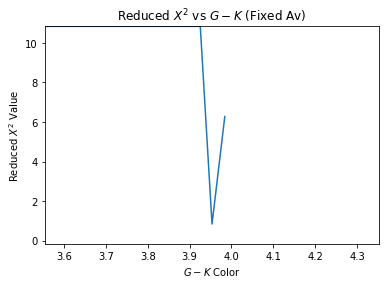

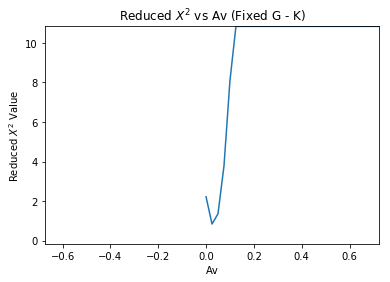

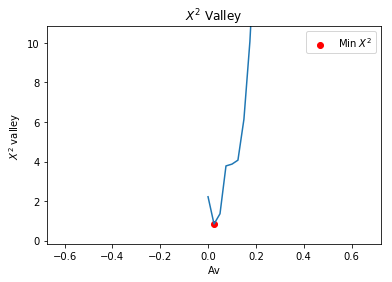

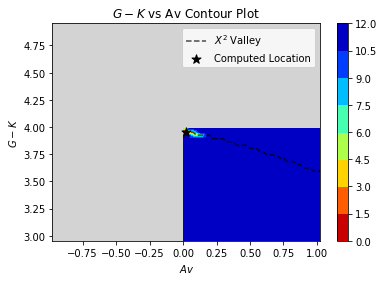


Index: 118
Factors Applied: [0.9999999999999999, 0.9999999999999999, 0.9999999999999999]
Reduced X^2: 0.8396224049700758 

Star SNR: 150.49489
Observed Star G-K: 3.9582369999999987
Computed Av: 0.025
COMPUTED AV: 0.025
Computed StarColor (G-K): 3.95346870803833

Diff in G-GB: 0.00619412667844732
Diff in G-GR: -0.0003788512224547347
Diff in G-J: -0.011281026423470397
Diff in G-H: 0.018111385013353853
Diff in G-K: 0.010303896993841821

Diff in G-GB Divided by Error: 0.8915841617411616
Diff in G-GR Divided by Error: -0.06630201415097958
Diff in G-J Divided by Error: -0.4618924921772629
Diff in G-H Divided by Error: 0.6869229486571317
Diff in G-K Divided by Error: 0.4412694456570199
Star Error: [0.004      0.00469732 0.004      0.024      0.026      0.023     ]
Quad Error: [0.00694733 0.00571402 0.02442349 0.02636596 0.02335058]


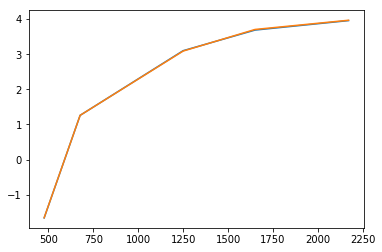

In [31]:
# Test Fudge Factors with X^2 Script

all_chi = []
all_Av = []
start = time.time()

extBands = cornerBands[n]
MagUncert = []

starGaiaFlux = cornerGaiaFluxs[n]
starGaiaFlux_er = cornerGaiaFlux_ers[n]
TmassError = cornerTmassErrors[n]

starSNR = cornerSNR[n]

for i in range(len(starGaiaFlux)):
    flux = starGaiaFlux[i]
    flux_er = starGaiaFlux_er[i]
    if(i == 0):
        Mag_er = MagError(flux,flux_er,0.004)
        MagUncert.append(Mag_er)
    else:
        Mag_er = MagError(flux,flux_er,0.004)
        MagUncert.append(Mag_er)
MagUncert = np.array(MagUncert)
MagUncert = np.append(MagUncert, TmassError)
MagUncert = MagUncert[~np.isnan(MagUncert)]
br = pickle.load(open('MainSequence_Av_CCM_Rv_4.1.pickle', 'rb'))
AV_list = np.array(br['Av'])
Temps = br['Temps']
curAv = Temps[AV_list[0]]
colors = np.array(curAv['Colors'])
Gkid = colors[:,4]

GKvals = []
AvChi = []
fits = []
allChi2Vals = []
RedChi2List = []
QuadErrors = []


for i in range(len(AV_list)):

    curAv = Temps[AV_list[i]]
    colors = np.array(curAv['Colors'])
    errors = np.array(curAv['Errors'])
    
    colors_copy = np.array(copy.copy(colors))
    colors_copy[:,0] = colors_copy[:,0]*fudges[0]
    colors_copy[:,1] = colors_copy[:,1]*fudges[1]
    colors_copy[:,2] = colors_copy[:,2]*fudges[2]
    colors_copy[:,3] = colors_copy[:,3]*fudges[2]
    colors_copy[:,4] = colors_copy[:,4]*fudges[2]
    
    Chi2 = []

    fit, chi, GKval, chi_array, Quad = StarFit(extBands,colors_copy,MagUncert,errors,Gkid)

    AvChi.append(chi)
    GKvals.append(GKval)
    fits.append(fit)
    allChi2Vals.append(chi)
    RedChi2List.append(chi_array)
    QuadErrors.append(Quad)
allChi2Vals = np.array(allChi2Vals)
RedChi2List = np.array(RedChi2List)
minVal = np.min(AvChi)
indexValue = AvChi.index(minVal)
extinction = AV_list[indexValue]
for i in range(len(AvChi)):
    if(AvChi[i] == np.min(AvChi)):
        all_Av.append(AV_list[i])
        ext = AV_list[i]
        mags = Temps[AV_list[i]]
        chi_val = AvChi[i]
        all_chi.append(allChi2Vals[i])
        GK_val = GKvals[i]
        bestfit = fits[i]
        index = i
        AllChisGK = RedChi2List[i]
        quadError = QuadErrors[i]
end = time.time()
print('Total Time:',end-start)
besttemp = mags['Colors']
bestTemp = np.array(copy.copy(besttemp))

bestTemp[:,0] = bestTemp[:,0]*fudges[0]
bestTemp[:,1] = bestTemp[:,1]*fudges[1]
bestTemp[:,2] = bestTemp[:,2]*fudges[2]
bestTemp[:,3] = bestTemp[:,3]*fudges[2]
bestTemp[:,4] = bestTemp[:,4]*fudges[2]

bestFit = np.array(bestTemp[bestfit])

curAv = Temps[AV_list[0]]
colorsZeroAv = np.array(curAv['Colors'])


X, Y = np.meshgrid(AV_list,colorsZeroAv[:,4])

XY = np.transpose([X,Y])
grid = XY[0]

for j in range(1,len(XY)):
    grid = np.vstack((grid,XY[j]))

Chi2List = copy.copy(RedChi2List)
Chi2List = Chi2List.ravel()    

test = copy.copy(Chi2List)
all_vals = np.reshape(test, (-1, 1))

all_vals = all_vals[:,0]
minChi = np.min(all_vals)
for i in range(len(all_vals)):
    if(all_vals[i] > chi_val+10):
        all_vals[i] = chi_val+10

x = len(colors)
y = len(AV_list)
all_vals = np.resize(all_vals, (y ,x))
all_vals = np.transpose(all_vals)

for i in range(len(AvChi)):
    if(AvChi[i] == np.min(AvChi)):
        
        index = i
# End For loop
     
# SECOND PLOT
plt.plot(colorsZeroAv[:,4],all_vals[:,index])
plt.ylim(chi_val-1,chi_val+10)
plt.xlim(GK_val-0.4,GK_val+0.4)
plt.title('Reduced $X^2$ vs $G-K$ (Fixed Av)')
plt.xlabel('$G-K$ Color')
plt.ylabel('Reduced $X^2$ Value')
plt.show()

GKcolors = np.array(copy.copy(colorsZeroAv[:,4]))
for i in range(len(GKcolors)):
    if(GKcolors[i] == GK_val):
        index2 = i
# THIRD PLOT
plt.plot(AV_list,all_vals[index2,:])
plt.ylim(chi_val-1,chi_val+10)
plt.xlim(ext-0.7,ext+0.7)
plt.title('Reduced $X^2$ vs Av (Fixed G - K)')
plt.xlabel('Av')
plt.ylabel('Reduced $X^2$ Value')
plt.show()

plt.plot(AV_list,allChi2Vals) # Original PLot
plt.scatter(ext,chi_val,c='r',label='Min $X^2$')
plt.xlabel('Av')
plt.ylabel('$X^2$ valley')
plt.ylim(chi_val-1.0,chi_val+10)
plt.xlim(ext-0.7,ext+0.7)
plt.title('$X^2$ Valley')
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.set_facecolor('lightgray')
plt.contourf(AV_list,colorsZeroAv[:,4],all_vals,7)
plt.set_cmap('jet_r')
plt.colorbar()
plt.xlabel('$Av$')
plt.ylabel('$G-K$')
plt.scatter(ext,GK_val,marker='*',label='Computed Location',c='k',s=90.0)
plt.plot(AV_list,GKvals,'k--',alpha=0.7,label='$X^2$ Valley')
#plt.scatter(GK_val,ext)
plt.ylim(GK_val-1.0,GK_val+1.0)
plt.xlim(ext-1.0,ext+1.0)
plt.title('$G-K$ vs Av Contour Plot')
plt.legend()
plt.show()
print('\nIndex:',n)
print('Factors Applied:',fudges)
print('Reduced X^2:',chi_val,'\n') 
print('Star SNR:',cornerSNR[n])
print('Observed Star G-K:',extBands[4])
print('Computed Av:',ext)
print('COMPUTED AV:',extinction)
print('Computed StarColor (G-K):',GK_val)
#print('Ratio of Colors:',extBands[4]/GK_val)
wvl = [477,677,1250,1650,2170]
plt.plot(wvl,extBands,label='Star')
plt.plot(wvl,bestFit)   
diffGB = bestFit[0] - extBands[0]
diffGR = bestFit[1] - extBands[1]
diffJ = bestFit[2] - extBands[2]
diffH = bestFit[3] - extBands[3]
diffK = bestFit[4] - extBands[4]
    
print('\nDiff in G-GB:',diffGB)
print('Diff in G-GR:',diffGR)
print('Diff in G-J:',diffJ)
print('Diff in G-H:',diffH)
print('Diff in G-K:',diffK)

print('\nDiff in G-GB Divided by Error:',diffGB/quadError[0])
print('Diff in G-GR Divided by Error:',diffGR/quadError[1])
print('Diff in G-J Divided by Error:',diffJ/quadError[2])
print('Diff in G-H Divided by Error:',diffH/quadError[3])
print('Diff in G-K Divided by Error:',diffK/quadError[4])
print('Star Error:',MagUncert)
print('Quad Error:',quadError)